# ml lab5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0. load dataset

In [2]:
!chmod +x ./download_data.sh 
!./download_data.sh

data/dogs-vs-cats already exist


### 1. train / test split

In [3]:
import os
import glob

In [26]:
image_shape = (128, 128, 3)

DATASET_PATH = './data/dogs-vs-cats/train'
    
def get_label(name):
    label = 'dog' if 'dog' in name else 'cat'
    return [name, label]

data_df = pd.DataFrame(
    data=[
        get_label(os.path.basename(image_path))
        for image_path in glob.glob(f'{DATASET_PATH}/*.jpg')
    ],
    columns=['name', 'label']
)
data_df.head()

,name,label
0,cat.5554.jpg,cat
1,cat.8958.jpg,cat
2,cat.2610.jpg,cat
3,cat.8360.jpg,cat
4,dog.9646.jpg,dog


In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

def generate_data(datagen, df, batch_size=64):
    return datagen.flow_from_dataframe(
        df, 
        DATASET_PATH, 
        x_col='name',
        y_col='label',
        target_size=image_shape[:-1],
        class_mode='binary',
        batch_size=batch_size
    )

datagen = ImageDataGenerator(rescale=1./255)
train_generator = generate_data(datagen, train_df)
test_generator = generate_data(datagen, test_df)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


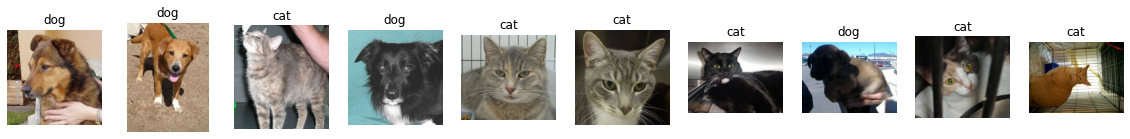

In [36]:
from random import randrange

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for ax in axs:
    i = randrange(train_df.shape[0])
    ax.imshow(plt.imread(f'{DATASET_PATH}/{train_df["name"][i]}'))
    ax.set_title(train_df['label'][i])
    ax.axis('off')

### 2. build network

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Dropout, Flatten

def build_model():
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=image_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [7]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 79 steps
Epoch 1/50
313/313 [==============================] - 177s 564ms/step - loss: 0.1648 - accuracy: 0.9356 - val_loss: 0.4378 - val_accuracy: 0.8388
Epoch 2/50
313/313 [==============================] - 177s 564ms/step - loss: 0.1422 - accuracy: 0.9449 - val_loss: 0.4538 - val_accuracy: 0.8448
Epoch 3/50
313/313 [==============================] - 177s 565ms/step - loss: 0.1107 - accuracy: 0.9582 - val_loss: 0.5196 - val_accuracy: 0.8352
Epoch 4/50
313/313 [==============================] - 177s 566ms/step - loss: 0.0925 - accuracy: 0.9647 - val_loss: 0.5537 - val_accuracy: 0.8482
Epoch 5/50
156/313 [=============>................] - ETA: 1:24 - loss: 0.0820 - accuracy: 0.9706

In [20]:
print(f'Train accuracy: {history.history["accuracy"][-1]*100:.2f}%')

Train accuracy: 97.86%


In [37]:
def plot(_history):    
    plt.figure(figsize=(8, 6))
    plt.plot(_history.history['accuracy'], 'r')
    plt.plot(_history.history['val_accuracy'], 'b')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

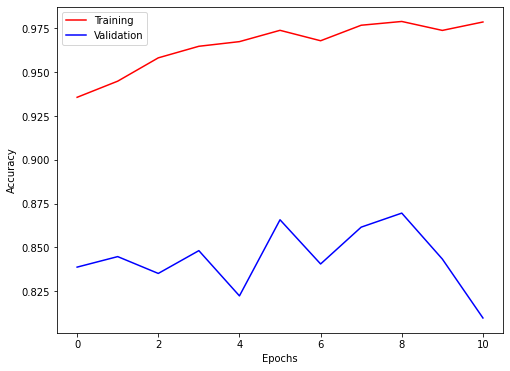

In [38]:
plot(history)

### 2. data augmentation

In [40]:
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = generate_data(datagen, train_df)

datagen = ImageDataGenerator(rescale=1./255)
test_generator = generate_data(datagen, test_df)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [41]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=test_generator,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 313 steps
Epoch 1/10
313/313 [==============================] - 246s 786ms/step - loss: 0.4176 - accuracy: 0.8095 - val_loss: 0.5354 - val_accuracy: 0.7480
Epoch 2/10
313/313 [==============================] - 246s 787ms/step - loss: 0.3877 - accuracy: 0.8278 - val_loss: 0.3834 - val_accuracy: 0.8269
Epoch 3/10
313/313 [==============================] - 246s 787ms/step - loss: 0.3568 - accuracy: 0.8425 - val_loss: 0.5951 - val_accuracy: 0.7511
Epoch 4/10
313/313 [==============================] - 246s 786ms/step - loss: 0.3515 - accuracy: 0.8444 - val_loss: 0.3584 - val_accuracy: 0.8365
Epoch 5/10
313/313 [==============================] - 246s 786ms/step - loss: 0.3534 - accuracy: 0.8425 - val_loss: 0.3412 - val_accuracy: 0.8501
Epoch 6/10
313/313 [==============================] - 246s 786ms/step - loss: 0.3332 - accuracy: 0.8533 - val_loss: 0.3766 - val_accuracy: 0.8286
Epoch 7/10
313/313 [==========

In [49]:
print(f'Train accuracy: {history.history["accuracy"][-1]*100:.2f}%')

Train accuracy: 87.35%


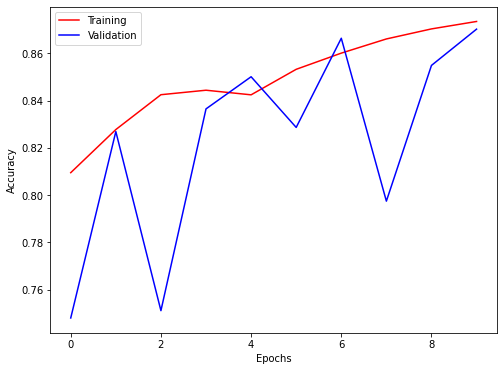

In [48]:
plot(history)

> augmentation prevents overfitting

### 4. Try VGG16

In [54]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

image_shape = (224, 224, 3)

pre_trained_model = VGG16(input_shape=image_shape, include_top=False, weights='imagenet')


for i, layer in enumerate(pre_trained_model.layers):
    layer.trainable = i > 15

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [56]:
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = generate_data(datagen, train_df)

datagen = ImageDataGenerator(rescale=1./255)
test_generator = generate_data(datagen, test_df)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=test_generator,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)